In [22]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [24]:
animal, sess_name = 'Rose', 'habituation1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [25]:
print(sess.eegfile)

duration: 3013.42 seconds 
duration: 0.84 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [26]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 22.2 seconds


,start,stop,label,duration
0,284.9252,287.0948,None,2.1696
1,1473.0000,1473.2500,None,0.2500
2,1528.6508,1530.1308,None,1.4800
3,2292.9044,2294.2212,None,1.3168
4,2333.2292,2338.8908,None,5.6616
5,2572.7540,2584.0908,None,11.3368


<Axes: >

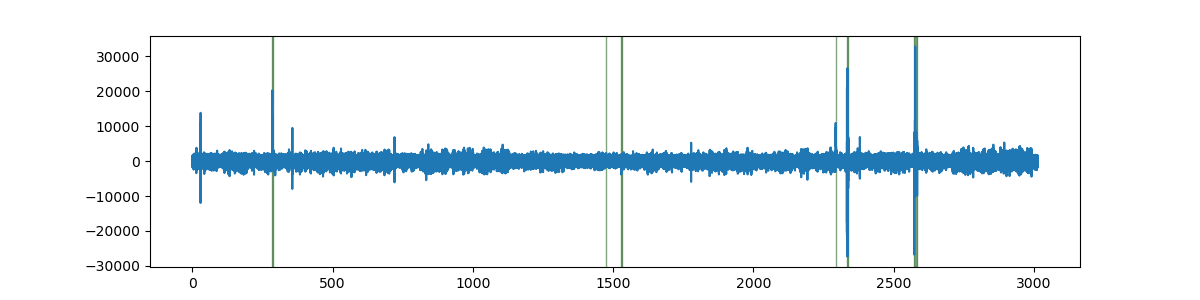

In [27]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.probegroup.npy saved


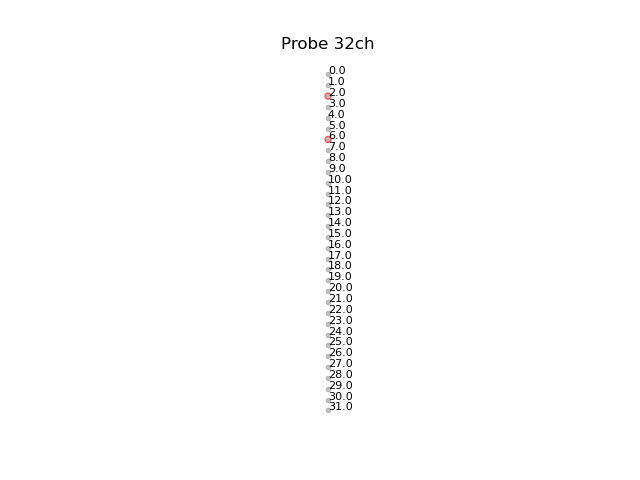

In [28]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [29]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [24]
232 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.theta_epochs.npy saved


## Detect SWR Epochs

In [30]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 24
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [24]
2869 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.ripple_epochs.npy saved


## Detect Delta

In [31]:
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 24

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)
sess.recinfo.write_epochs(delta_epochs, ext='dta')
delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs.save(delta_epochs_file)

192 delta waves detected
/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.delta_epochs.npy saved


In [32]:
#Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 24
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(beta_epochs, ext='bta')
beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs.save(beta_epochs_file)

Best channel for beta: [24]
194 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.beta_epochs.npy saved


In [33]:
# Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 0.5 
highthresh = 5
minDistance = 200
minDuration = 100
gamma_channel = 24

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
sess.recinfo.write_epochs(gamma_epochs, ext='gma')
gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs.save(gamma_epochs_file)

/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.gamma_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [34]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

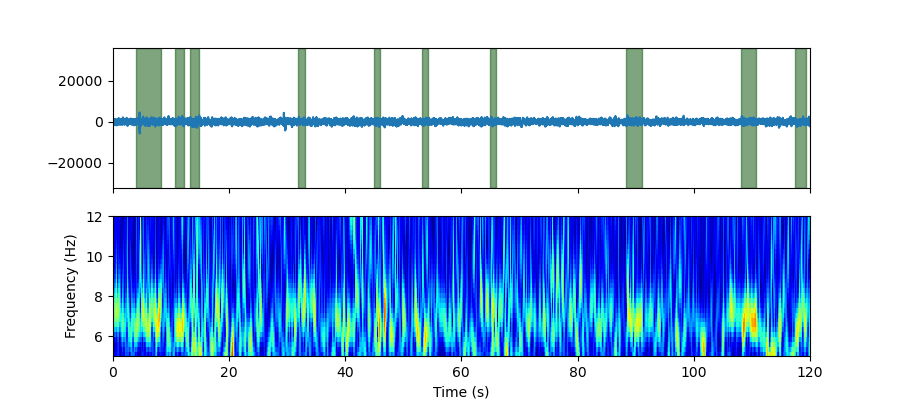

In [35]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

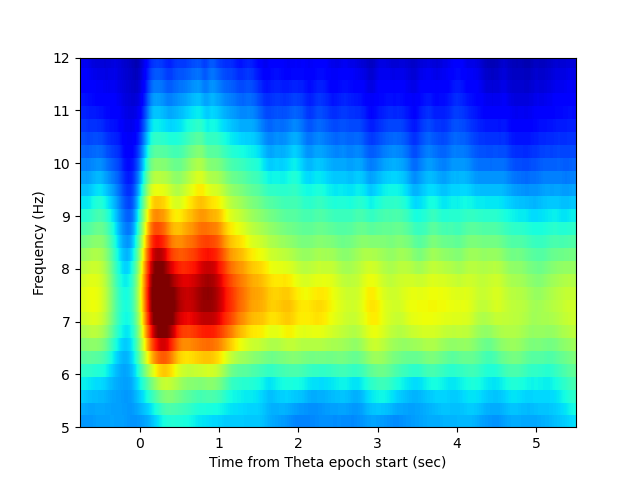

In [36]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [37]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

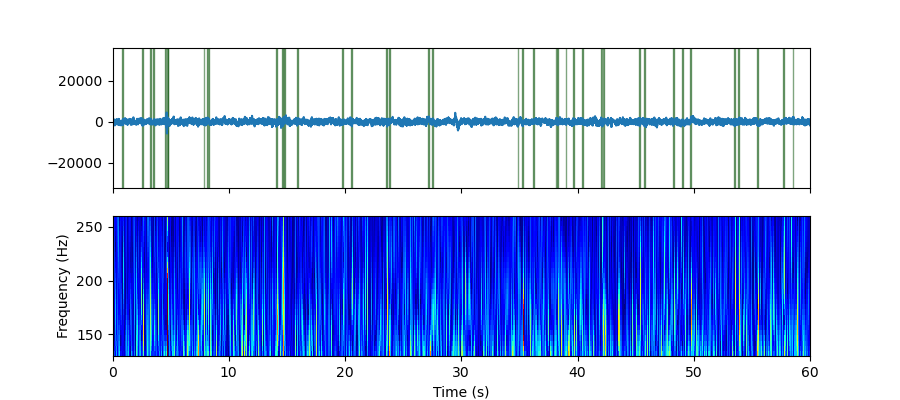

In [38]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Delta

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

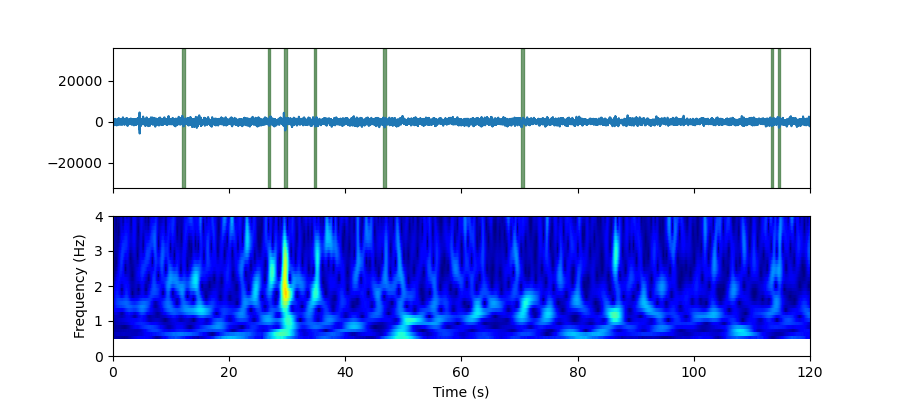

In [39]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
delta_freq_lims = [0.5, 4]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

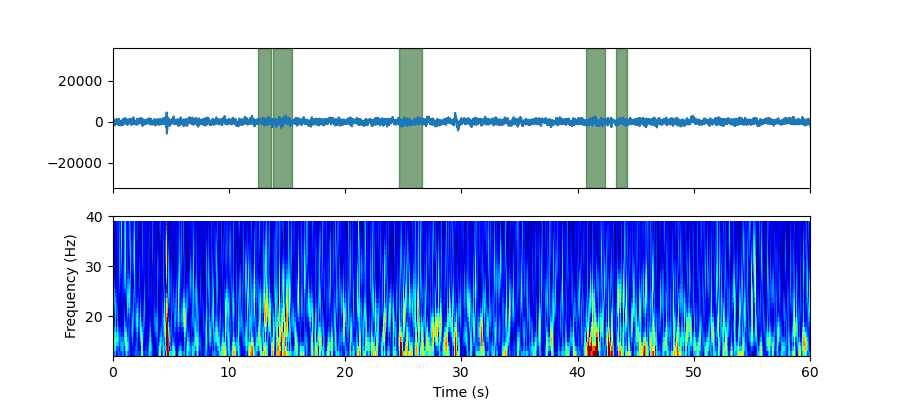

In [40]:
## Beta
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

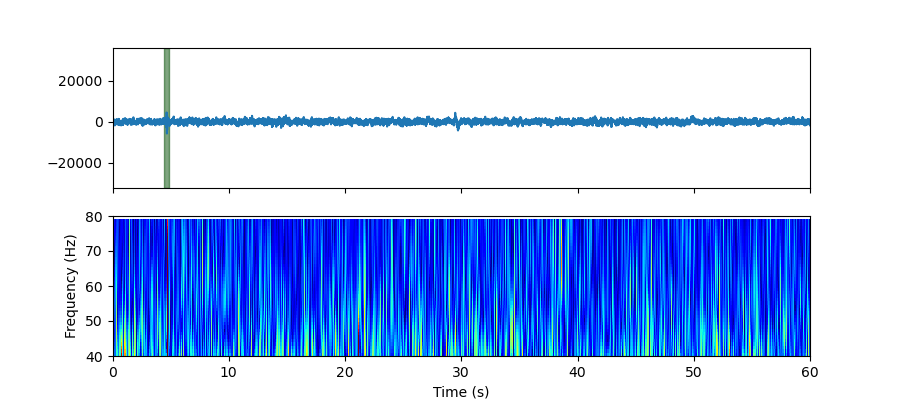

In [41]:
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

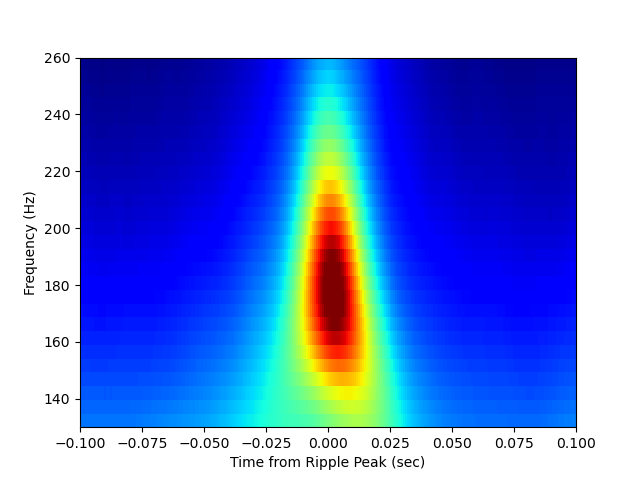

In [42]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-USV analyses

In [43]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

28 epochs
Snippet: 
        start       stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0   9.288669   9.335200    9.288669  43.404412  0.046532    6.536199      1   
1   9.459285   9.497199    9.459285  39.773190  0.037915    6.173077      1   
2  11.473934  11.543731   11.473934  44.493778  0.069798   10.288462      1   
3  16.281792  16.304206   16.281792  50.545814  0.022414   12.830317      1   
4  16.326605  16.355903   16.326605  49.335407  0.029298    9.804299      1   

   Accept label  nrec  t_start_eeg  t_stop_eeg  
0       1           0    55.911355   55.957871  
1       1           0    56.081914   56.119816  
2       1           0    58.095888   58.165662  
3       1           0    62.902137   62.924543  
4       1           0    62.946935   62.976223  

In [44]:
usv_epochs._epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label,nrec,t_start_eeg,t_stop_eeg
0,9.288669,9.335200,9.288669,43.404412,0.046532,6.536199,1,1,,0,55.911355,55.957871
1,9.459285,9.497199,9.459285,39.773190,0.037915,6.173077,1,1,,0,56.081914,56.119816
2,11.473934,11.543731,11.473934,44.493778,0.069798,10.288462,1,1,,0,58.095888,58.165662
3,16.281792,16.304206,16.281792,50.545814,0.022414,12.830317,1,1,,0,62.902137,62.924543
4,16.326605,16.355903,16.326605,49.335407,0.029298,9.804299,1,1,,0,62.946935,62.976223
5,18.719539,18.786752,18.719539,43.283371,0.067212,9.562217,1,1,,0,65.339068,65.406257
6,44.802671,44.950022,44.802671,48.730204,0.147350,26.144796,1,1,,0,91.413466,91.560767
7,46.027513,46.074907,46.027513,46.551471,0.047393,7.625566,1,1,,0,92.637898,92.685275
8,59.612667,59.672124,59.612667,40.378394,0.059457,26.386878,1,1,,0,106.218502,106.277939
9,60.218009,60.300732,60.218009,44.372738,0.082723,28.444570,1,1,,0,106.823642,106.906337


In [45]:
usv_epochs._epochs.Duration.mean()

0.04903193312525321

In [48]:
art_epochs

6 epochs
Snippet: 
        start       stop label
0   284.9252   287.0948  None
1  1473.0000  1473.2500  None
2  1528.6508  1530.1308  None
3  2292.9044  2294.2212  None
4  2333.2292  2338.8908  None

## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start(sec)')

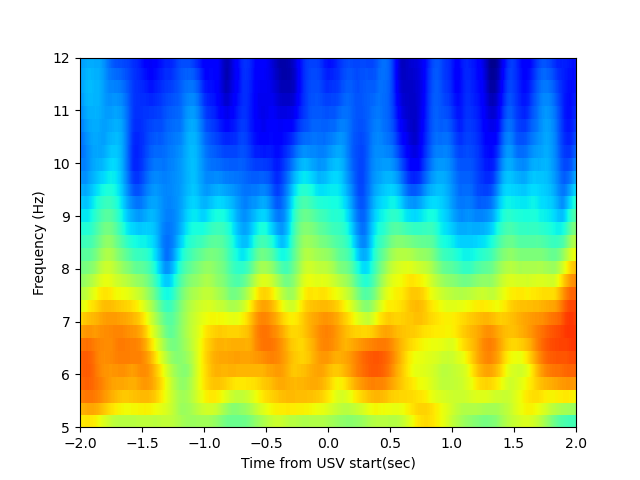

In [47]:
# Example code to plot theta at USV starts
usv_buffer_sec = (2, 2)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Ripple mean spectrogram

Events [0 1] are outside of data range and were dropped
2712 frames between 284.9 and 287.1 ignored (sent to nan)
1560 frames between 285.8 and 287.1 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

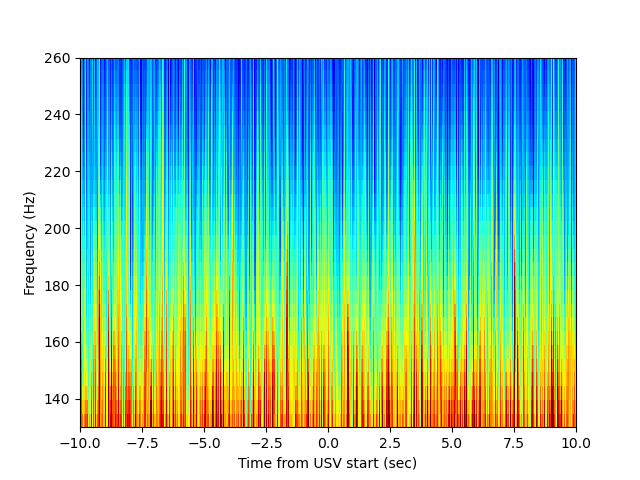

In [49]:
# All
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Delta

Events [0 1] are outside of data range and were dropped
2712 frames between 284.9 and 287.1 ignored (sent to nan)
1560 frames between 285.8 and 287.1 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

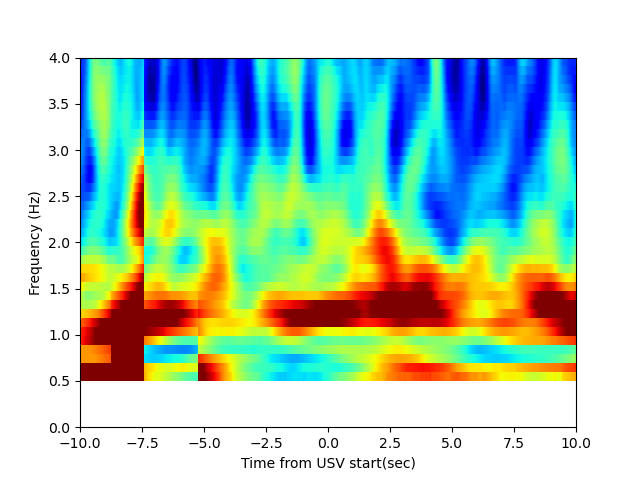

In [50]:
#Delta
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

Events [0 1] are outside of data range and were dropped
2712 frames between 284.9 and 287.1 ignored (sent to nan)
1560 frames between 285.8 and 287.1 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/plotting/signals.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

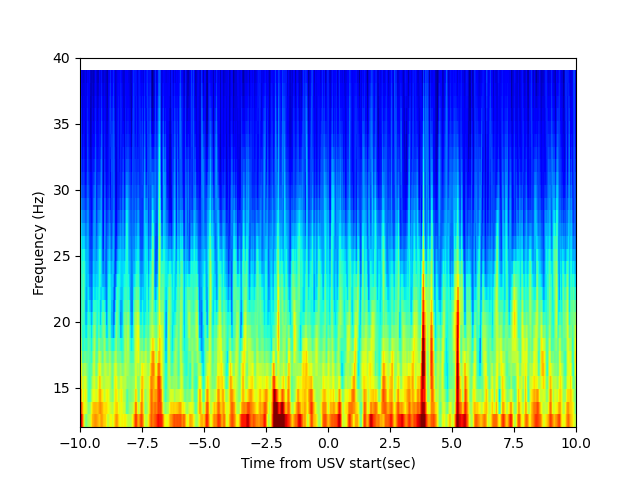

In [51]:
#Beta
usv_buffer_sec = (10, 10)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

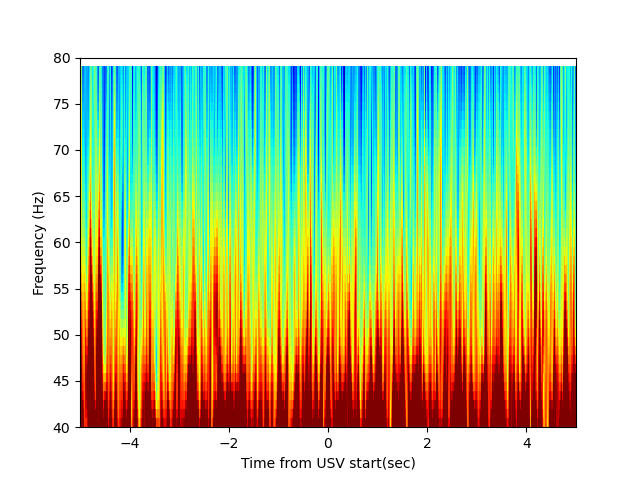

In [52]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Finn recall7 note:
pyr channel (26) has weird-looking oscillations particularly during CS- and CS+(2) times.  I have used channel 20 instead which is well above the cell layer but has good-looking volume-conducted theta.  SWR detection appears to be fine using ch 26.

## Save notebook to working directory

In [53]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Animal_files/USV_Spectral_Analysis(Rose_habituation1).ipynb saved to /data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_USV_Spectral_Analysis(Rose_habituation1).ipynb


In [54]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.
